In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.optim as optim
import missingno as msno

In [2]:
df = pd.read_csv("../datathon/dataset/product_data.csv")
outfit_data = pd.read_csv("../datathon/dataset/outfit_data.csv")
print(df.head(), outfit_data.head())

  cod_modelo_color cod_color_code des_color_specification_esp   
0      41085800-02             02                    OFFWHITE  \
1      53000586-TO             TO               TEJANO OSCURO   
2      53030601-81             81                 ROSA PASTEL   
3      53050730-15             15                     MOSTAZA   
4      53070773-70             70                        ROJO   

  des_agrup_color_eng des_sex des_age des_line des_fabric   
0               WHITE  Female   Adult      SHE    P-PLANA  \
1                BLUE  Female   Adult      SHE    J-JEANS   
2                PINK  Female   Adult      SHE    P-PLANA   
3              YELLOW  Female   Adult      SHE    P-PLANA   
4                 RED  Female   Adult      SHE    P-PLANA   

                  des_product_category des_product_aggregated_family   
0                              Bottoms           Trousers & leggings  \
1                              Bottoms                         Jeans   
2  Dresses, jumpsuits and 

In [3]:
df.describe()

,cod_modelo_color,cod_color_code,des_color_specification_esp,des_agrup_color_eng,des_sex,des_age,des_line,des_fabric,des_product_category,des_product_aggregated_family,des_product_family,des_product_type,des_filename
count,9222,9222,9222,9222,9222,9222,9222,9222,9222,9222,9222,9222,9222
unique,9222,110,110,10,3,2,5,7,7,16,39,123,9222
top,41085800-02,99,NEGRO,GREY,Female,Adult,SHE,P-PLANA,Tops,Accessories,Dresses,Dress,datathon/images/2019_41085800_02.jpg
freq,1,2119,2119,2907,9170,9203,9144,3041,2768,2466,1189,1188,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9222 entries, 0 to 9221
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   cod_modelo_color               9222 non-null   object
 1   cod_color_code                 9222 non-null   object
 2   des_color_specification_esp    9222 non-null   object
 3   des_agrup_color_eng            9222 non-null   object
 4   des_sex                        9222 non-null   object
 5   des_age                        9222 non-null   object
 6   des_line                       9222 non-null   object
 7   des_fabric                     9222 non-null   object
 8   des_product_category           9222 non-null   object
 9   des_product_aggregated_family  9222 non-null   object
 10  des_product_family             9222 non-null   object
 11  des_product_type               9222 non-null   object
 12  des_filename                   9222 non-null   object
dtypes: 

**Preprocessing Data**

In [5]:
# Creating new feature that is a list showcasing what outfits does each product appear in
outfits_agrupados = outfit_data.groupby('cod_modelo_color')['cod_outfit'].apply(list).reset_index()
outfits_agrupados.head()
df_combinado = pd.merge(df, outfits_agrupados, on='cod_modelo_color', how='left')
df_combinado.head()


,cod_modelo_color,cod_color_code,des_color_specification_esp,des_agrup_color_eng,des_sex,des_age,des_line,des_fabric,des_product_category,des_product_aggregated_family,des_product_family,des_product_type,des_filename,cod_outfit
0,41085800-02,02,OFFWHITE,WHITE,Female,Adult,SHE,P-PLANA,Bottoms,Trousers & leggings,Trousers,Trousers,datathon/images/2019_41085800_02.jpg,"[1769, 1396, 683]"
1,53000586-TO,TO,TEJANO OSCURO,BLUE,Female,Adult,SHE,J-JEANS,Bottoms,Jeans,Jeans,Jeans,datathon/images/2019_53000586_TO.jpg,"[629, 616, 576, 2103, 2527, 1644, 4285, 7617, ..."
2,53030601-81,81,ROSA PASTEL,PINK,Female,Adult,SHE,P-PLANA,"Dresses, jumpsuits and Complete set",Dresses and jumpsuits,Dresses,Dress,datathon/images/2019_53030601_81.jpg,[1166]
3,53050730-15,15,MOSTAZA,YELLOW,Female,Adult,SHE,P-PLANA,"Dresses, jumpsuits and Complete set",Dresses and jumpsuits,Dresses,Dress,datathon/images/2019_53050730_15.jpg,[1593]
4,53070773-70,70,ROJO,RED,Female,Adult,SHE,P-PLANA,Tops,Shirts,Shirt,Shirt,datathon/images/2019_53070773_70.jpg,[2019]


In [8]:
df.isna().sum()


cod_modelo_color                 0
cod_color_code                   0
des_color_specification_esp      0
des_agrup_color_eng              0
des_sex                          0
des_age                          0
des_line                         0
des_fabric                       0
des_product_category             0
des_product_aggregated_family    0
des_product_family               0
des_product_type                 0
des_filename                     0
dtype: int64

<Axes: >

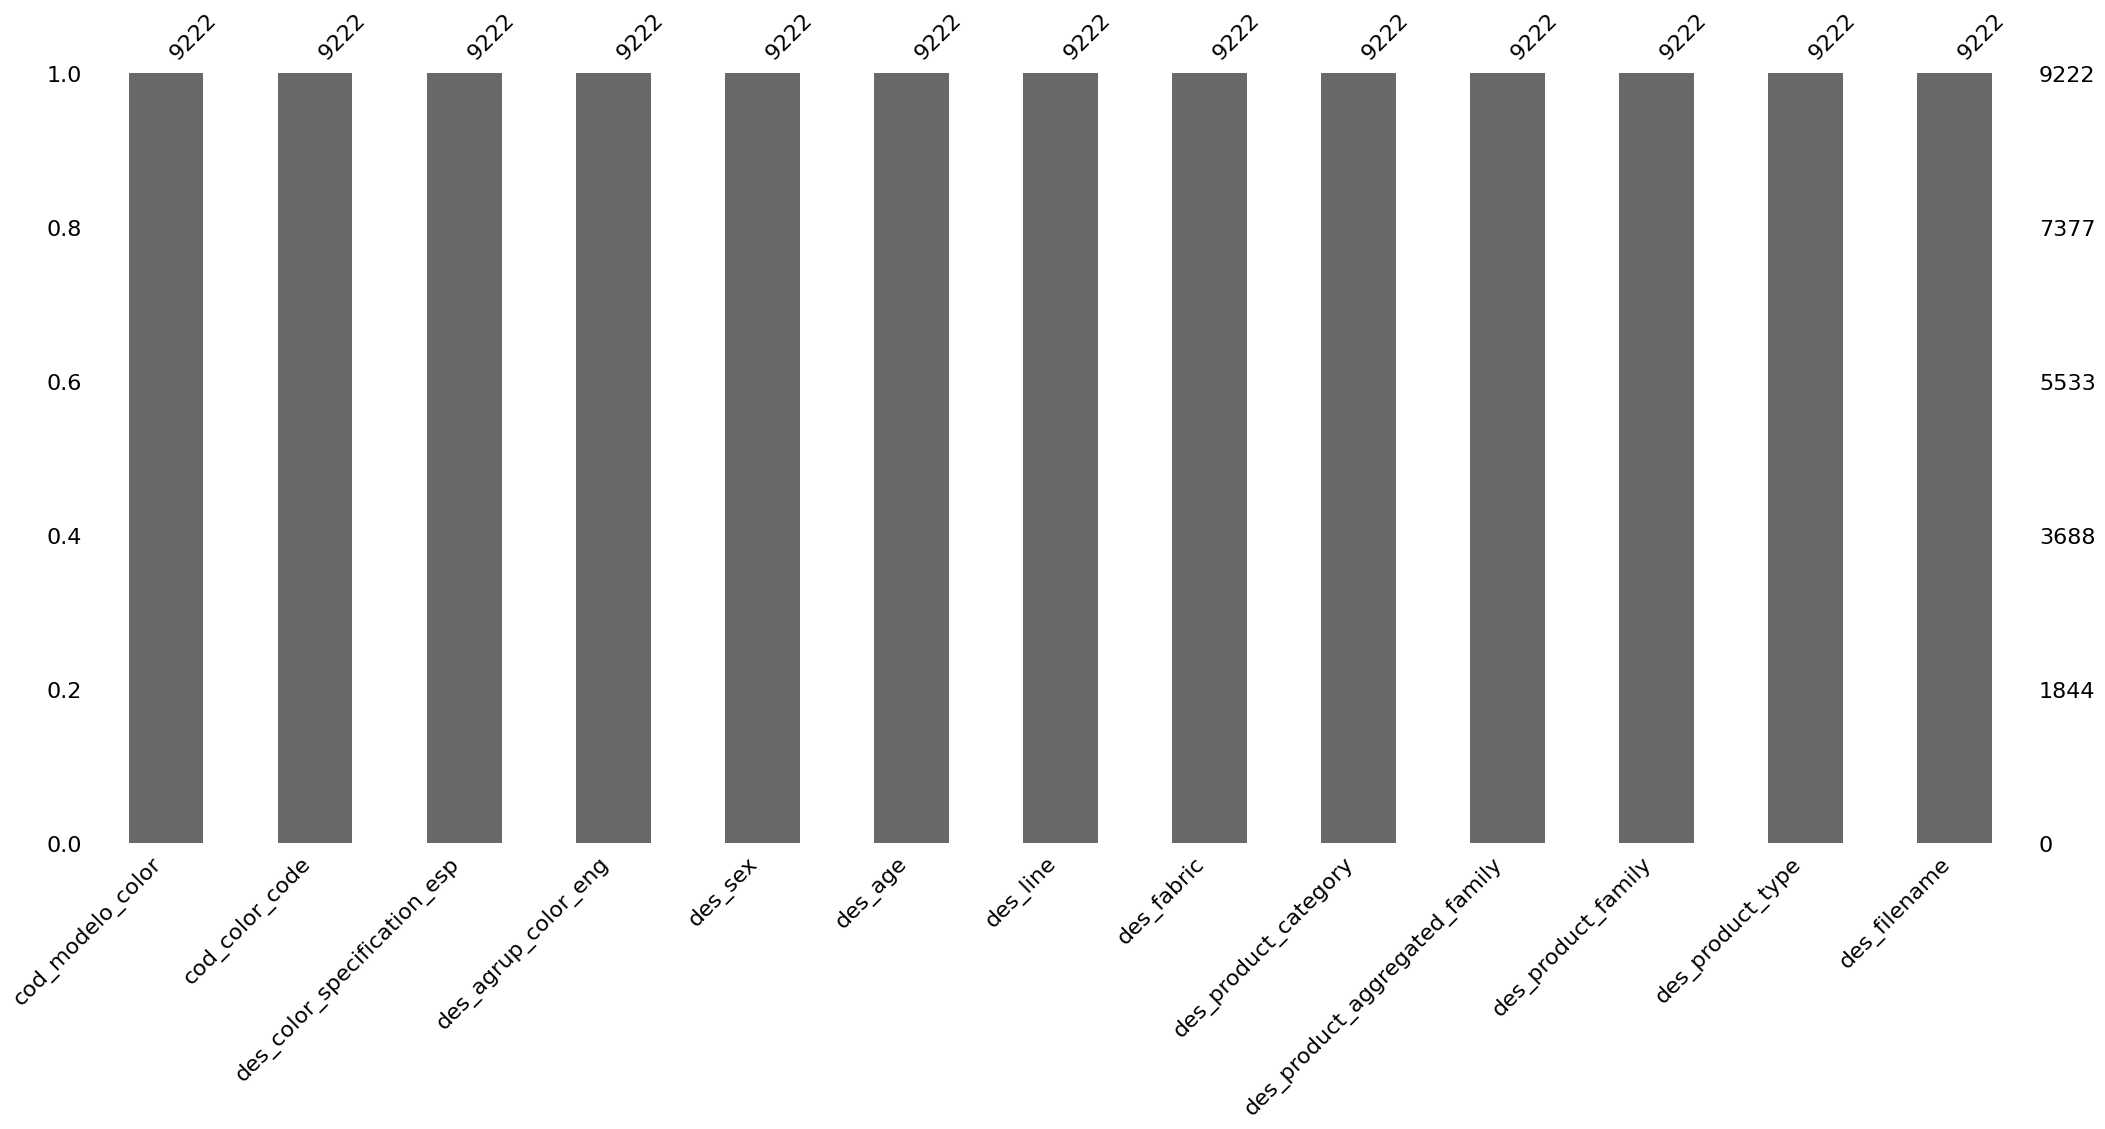

In [9]:
msno.bar(df)


In [13]:
categorical_columns = ["cod_color_code","des_color_specification_esp","des_agrup_color_eng","des_sex","des_age","des_line","des_fabric","des_product_category","des_product_aggregated_family","des_product_family","des_product_type"]

for column in categorical_columns:
    df[column] = df[column].astype('category')


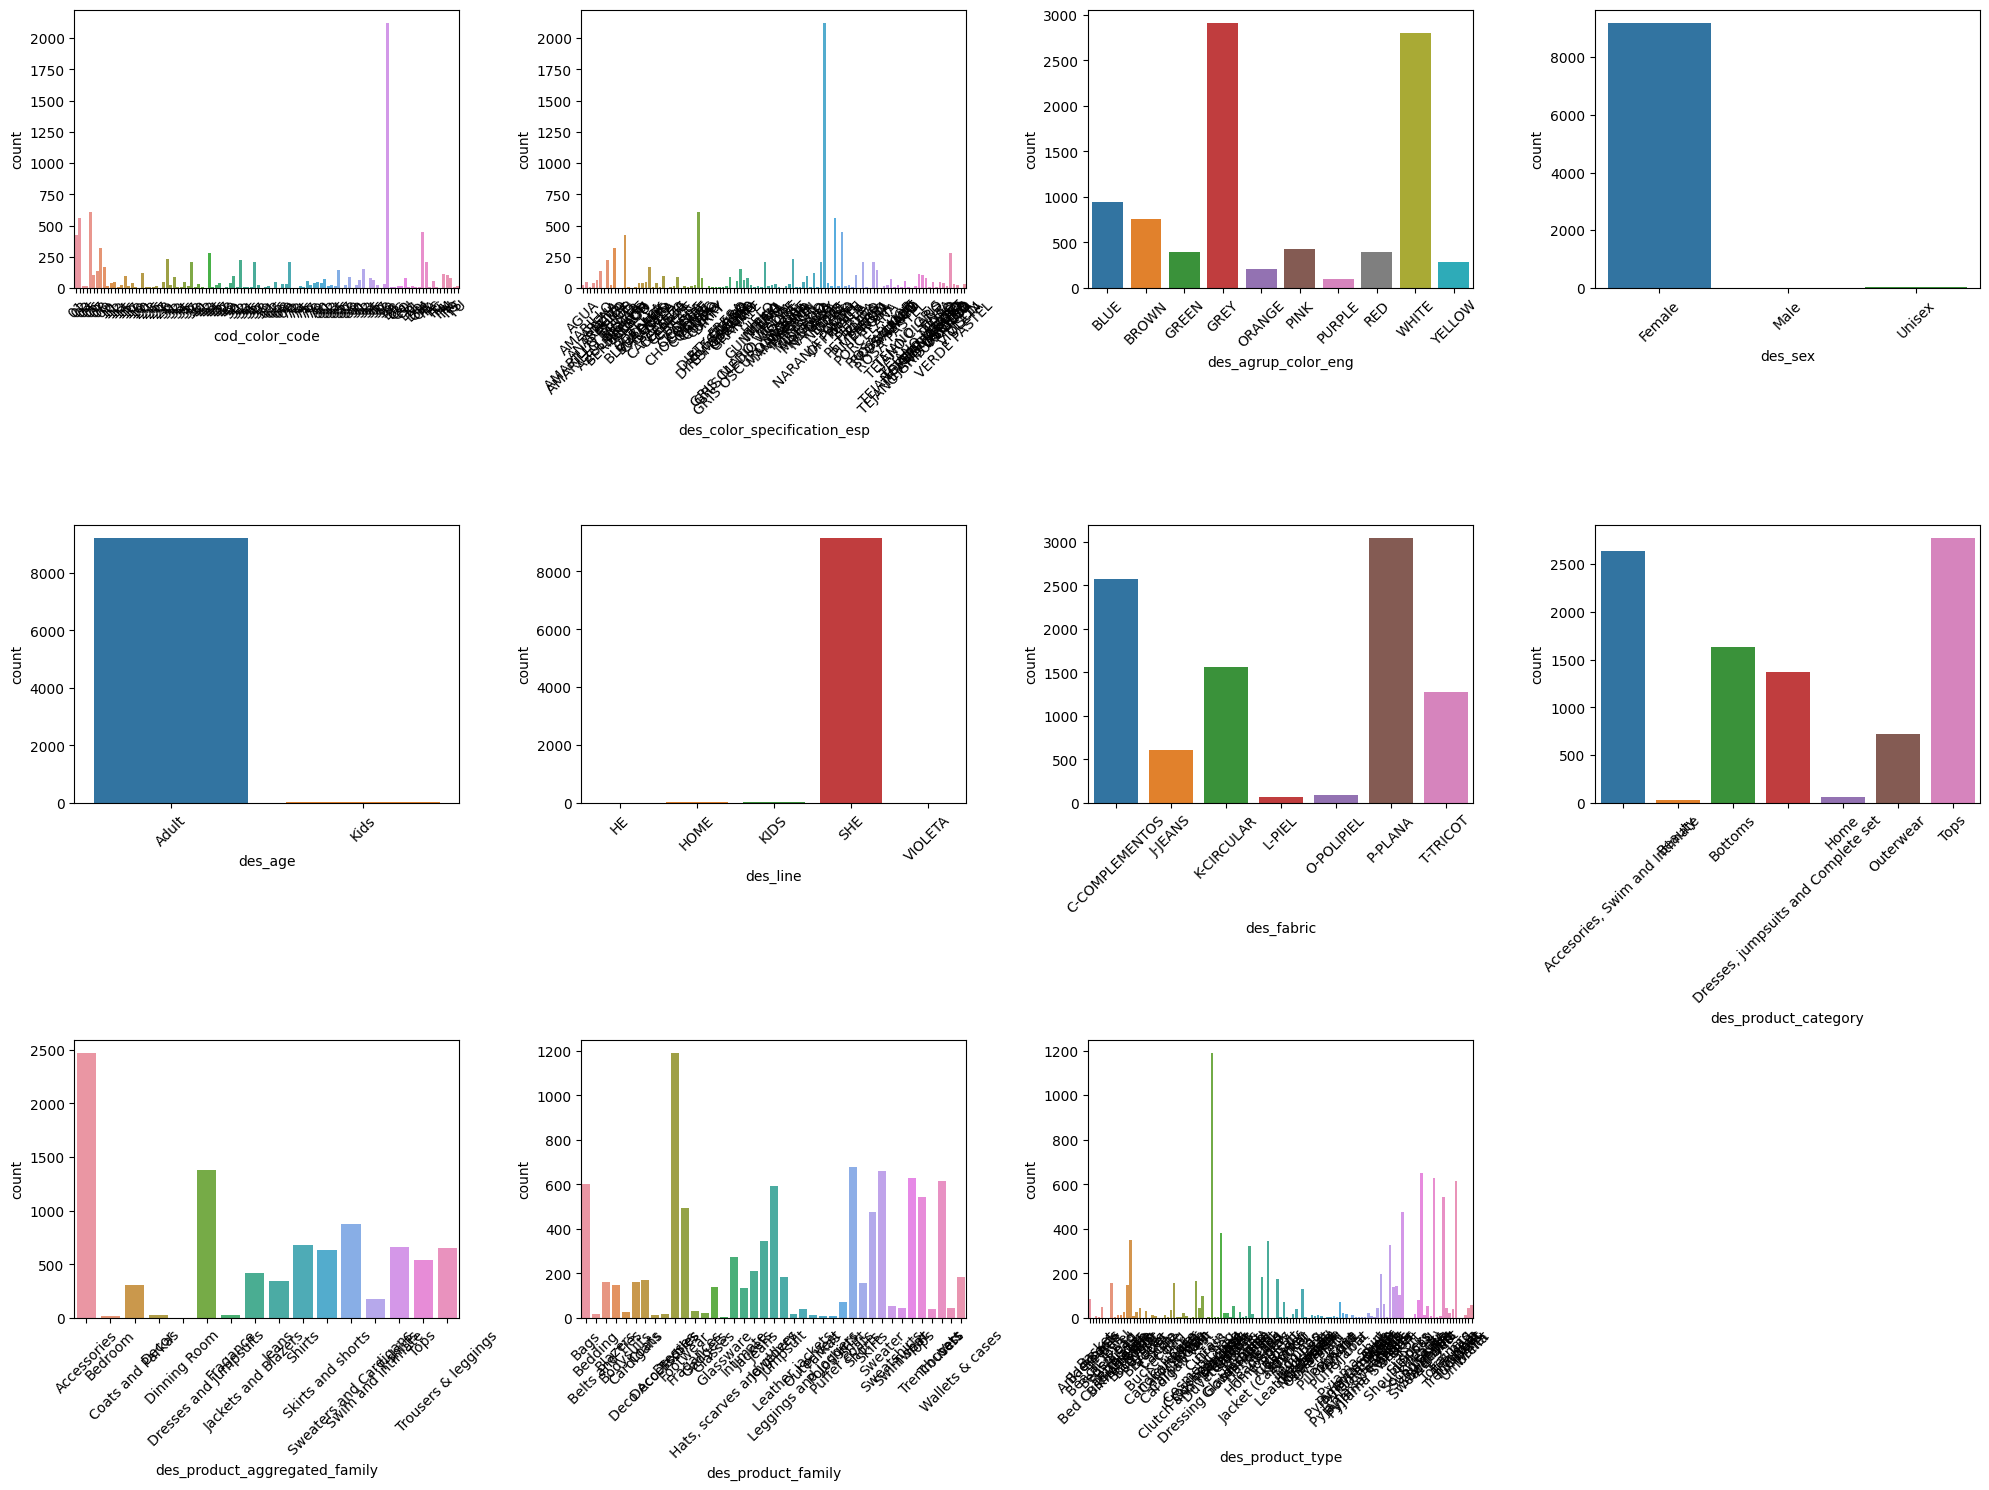

In [14]:
plt.figure(figsize=(20, 15))
plotnumber = 1

for column in df:
    if plotnumber <= 12 and pd.api.types.is_categorical_dtype(df[column]):
        ax = plt.subplot(3, 4, plotnumber)
        sns.countplot(x=df[column])
        plt.xlabel(column)
        plt.xticks(rotation=45)
        plotnumber += 1

plt.tight_layout()
plt.show()
